In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import scipy.sparse as sp
from scipy.linalg import eig
from torch_geometric.utils import to_scipy_sparse_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV

np.random.seed(42)

Question 1

Spectral Clustering


In [2]:
cora_graph = Planetoid(root='/tmp/Cora', name='Cora')
citeseer_graph = Planetoid(root='/tmp/Citeseer', name='Citeseer')
cora_network = to_networkx(cora_graph[0], to_undirected=True)
citeseer_network = to_networkx(citeseer_graph[0], to_undirected=True)

# fix the layout of the graph for visualization
layout_cora = nx.spring_layout(cora_network, seed = 42)
layout_citeseer = nx.spring_layout(citeseer_network, seed = 42)

# Remove nodes with degree 0
citeseer_network.remove_nodes_from(list(nx.isolates(citeseer_network)))

In [3]:
num_nodes_cora = cora_network.number_of_nodes()
num_nodes_citeseer = citeseer_network.number_of_nodes()

print(num_nodes_cora)
print(num_nodes_citeseer)

2708
3279


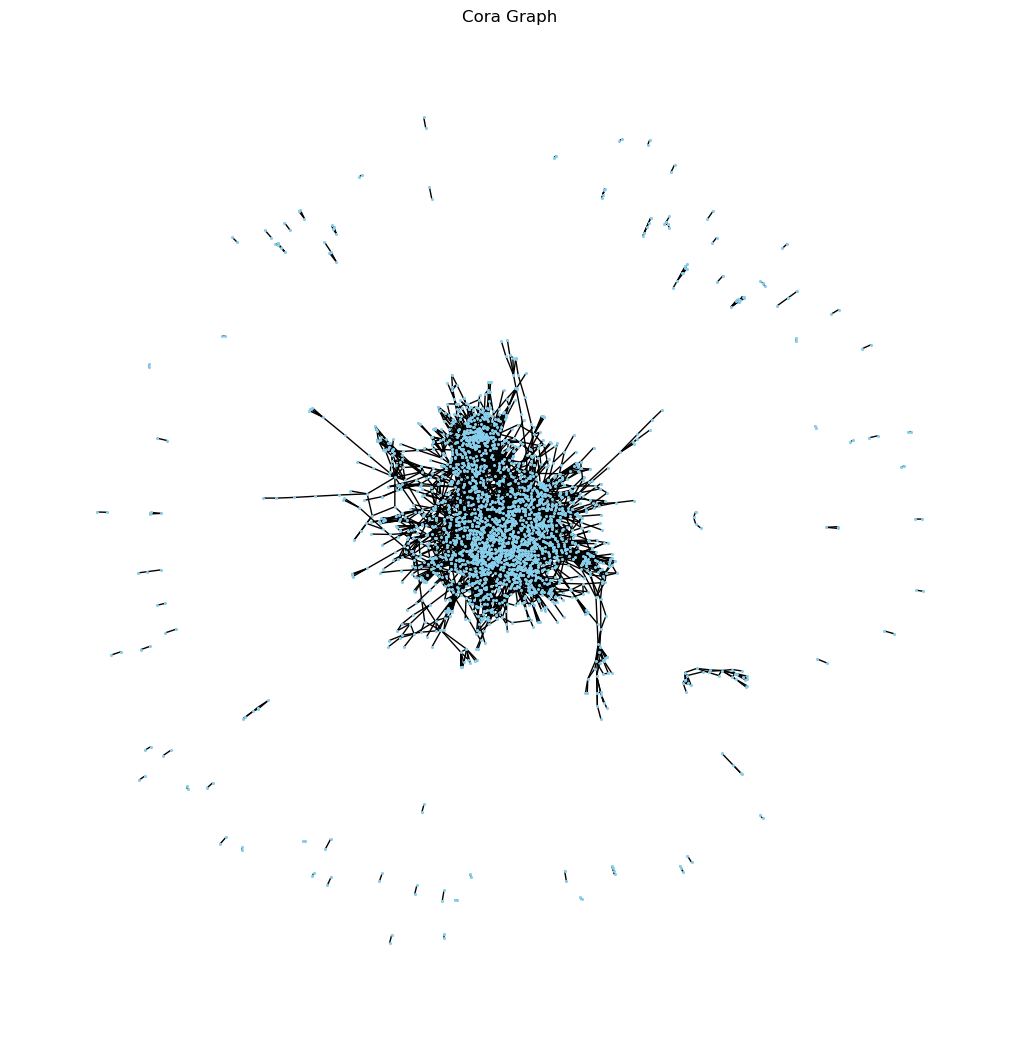

In [4]:
plt.figure(figsize=(10, 10))
nx.draw(cora_network,layout_cora, with_labels=False, node_color='skyblue', node_size=1.5, edge_color='k')
plt.title('Cora Graph') 
plt.show()

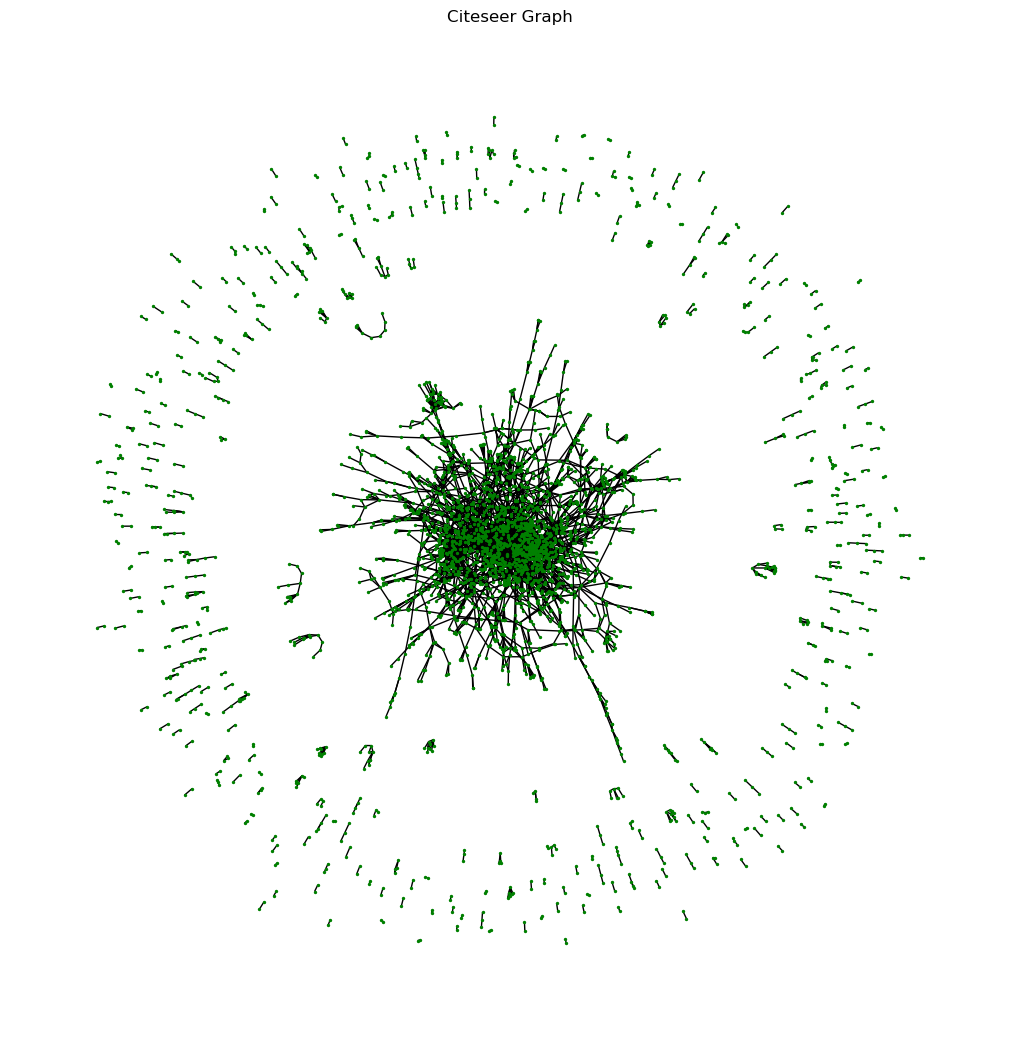

In [5]:
plt.figure(figsize=(10, 10))
nx.draw(citeseer_network,layout_citeseer, with_labels=False, node_color='green', node_size=2, edge_color='k')
plt.title('Citeseer Graph') 
plt.show()

In [6]:
# Get the degree of each node
degree_sequence_cora = [d for n, d in cora_network.degree()]
degree_sequence_citeseer = [d for n, d in citeseer_network.degree()]

Text(0.5, 1.0, 'Degree distribution of Cora graph')

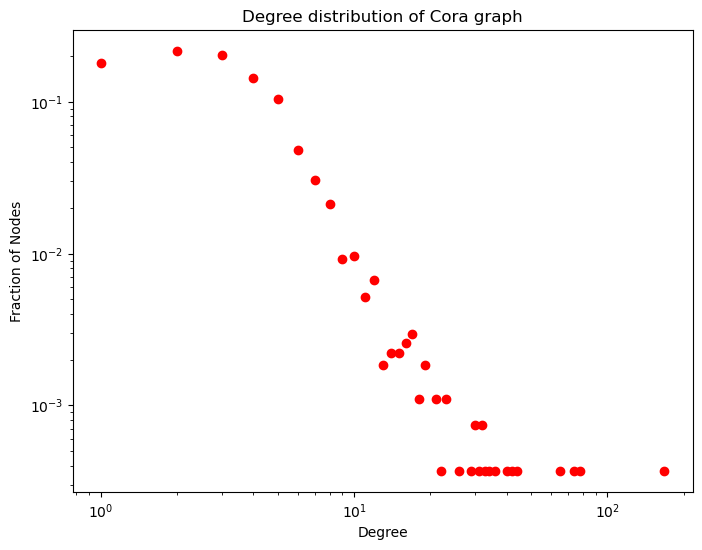

In [7]:
# Compute the histogram of the degree distribution
degree_counts_cora, bin_edges_cora = np.histogram(degree_sequence_cora, bins=range(1, np.max(degree_sequence_cora) + 2), density=True)
degree_counts_citeseer, bin_edges_citeseer = np.histogram(degree_sequence_citeseer, bins=range(1, np.max(degree_sequence_citeseer) + 2), density=True)

# Plot the degree distribution
plt.figure(figsize=(8, 6))
plt.plot(bin_edges_cora[:-1], degree_counts_cora, 'o', color='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.title('Degree distribution of Cora graph')
# plt.savefig('cora_degree_distribution.png')


Text(0.5, 1.0, 'Degree distribution of Citeseer graph')

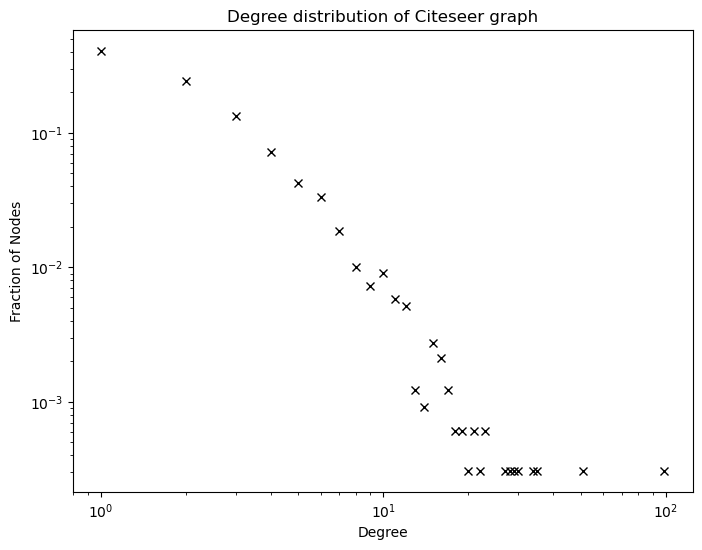

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(bin_edges_citeseer[:-1], degree_counts_citeseer, 'x', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.title('Degree distribution of Citeseer graph')
# plt.savefig('citeseer_degree_distribution.png')

In [9]:
# Convert the graph to a scipy sparse matrix
adj_cora = to_scipy_sparse_matrix(cora_graph[0].edge_index)
adj_cora = np.matrix(adj_cora.todense())
 
# Compute the degree matrix
degrees_cora = np.array(adj_cora.sum(axis=1)).flatten()

D_cora = sp.diags(degrees_cora)

# Compute the unnormalized Laplacian
L_unnormalized_cora = D_cora - adj_cora

# Compute the normalized Laplacian
D_sqrt_inv_cora = sp.diags(1.0 / np.sqrt(degrees_cora))
L_normalized_cora = sp.eye(adj_cora.shape[0]) - D_sqrt_inv_cora @ adj_cora @ D_sqrt_inv_cora

# Compute the random walk Laplacian
D_inv_cora = sp.diags(1.0 / degrees_cora)
L_rw_cora = sp.eye(adj_cora.shape[0]) - D_inv_cora @ adj_cora

# Compute the eigenvalues of the Laplacians
unnormalized_eigvals_cora, unnormalized_eigvecs_cora = eig(L_unnormalized_cora)
normalized_eigvals_cora, normalized_eigvecs_cora = eig(L_normalized_cora)
rw_eigvals_cora, rw_eigvecs_cora = eig(L_rw_cora)

# Get the indices that would sort the eigenvalues
sort_indices_unnormalized_cora = np.argsort(unnormalized_eigvals_cora)
sort_indices_normalized_cora = np.argsort(normalized_eigvals_cora)
sort_indices_rw_cora = np.argsort(rw_eigvals_cora)

# Use these indices to sort the eigenvalues and eigenvectors
sorted_eigvals_unnormalized_cora = unnormalized_eigvals_cora[sort_indices_unnormalized_cora]
sorted_eigvecs_unnormalized_cora = unnormalized_eigvecs_cora[:, sort_indices_unnormalized_cora]

sorted_eigvals_normalized_cora = unnormalized_eigvals_cora[sort_indices_normalized_cora]
sorted_eigvecs_normalized_cora = unnormalized_eigvecs_cora[:, sort_indices_normalized_cora]

sorted_eigvals_rw_cora = unnormalized_eigvals_cora[sort_indices_rw_cora]
sorted_eigvecs_rw_cora = unnormalized_eigvecs_cora[:, sort_indices_rw_cora]


print('Unnormalized Laplacian eigenvalues:', np.sort(unnormalized_eigvals_cora)[78])
print('Normalized Laplacian eigenvalues:', np.sort(normalized_eigvals_cora)[78])
print('Random walk Laplacian eigenvalues:', np.sort(rw_eigvals_cora)[78])

Unnormalized Laplacian eigenvalues: (0.0148013355+0j)
Normalized Laplacian eigenvalues: (0.004783995235151357+0j)
Random walk Laplacian eigenvalues: (0.004783981018607238+0j)


79'th (78 is index) eigenvector is the fiedler vector

In [10]:
def kmeans(X,k):
    np.random.seed(42)
    indices = np.random.choice(len(X), k, replace=False)
    print(indices)
    centroids = X[indices, :]
    for _ in range(100): # maximum iterations
        # Assign labels based on closest centroid
        labels = np.argmin(np.linalg.norm(X - centroids[:, np.newaxis], axis=2), axis=0)
        # Find new centroids
        new_centroids = np.array([X[labels==i].mean(0) for i in range(k)])
        # Check for convergence
        if np.all(centroids == new_centroids):
            print('Converged in {} iterations'.format(_))
            break
            
        centroids = new_centroids
    return labels, centroids

[1044  439 1729  296 2211  479 1084]
Converged in 23 iterations
[1044  439 1729  296 2211  479 1084]
Converged in 26 iterations
[1044  439 1729  296 2211  479 1084]
Converged in 22 iterations


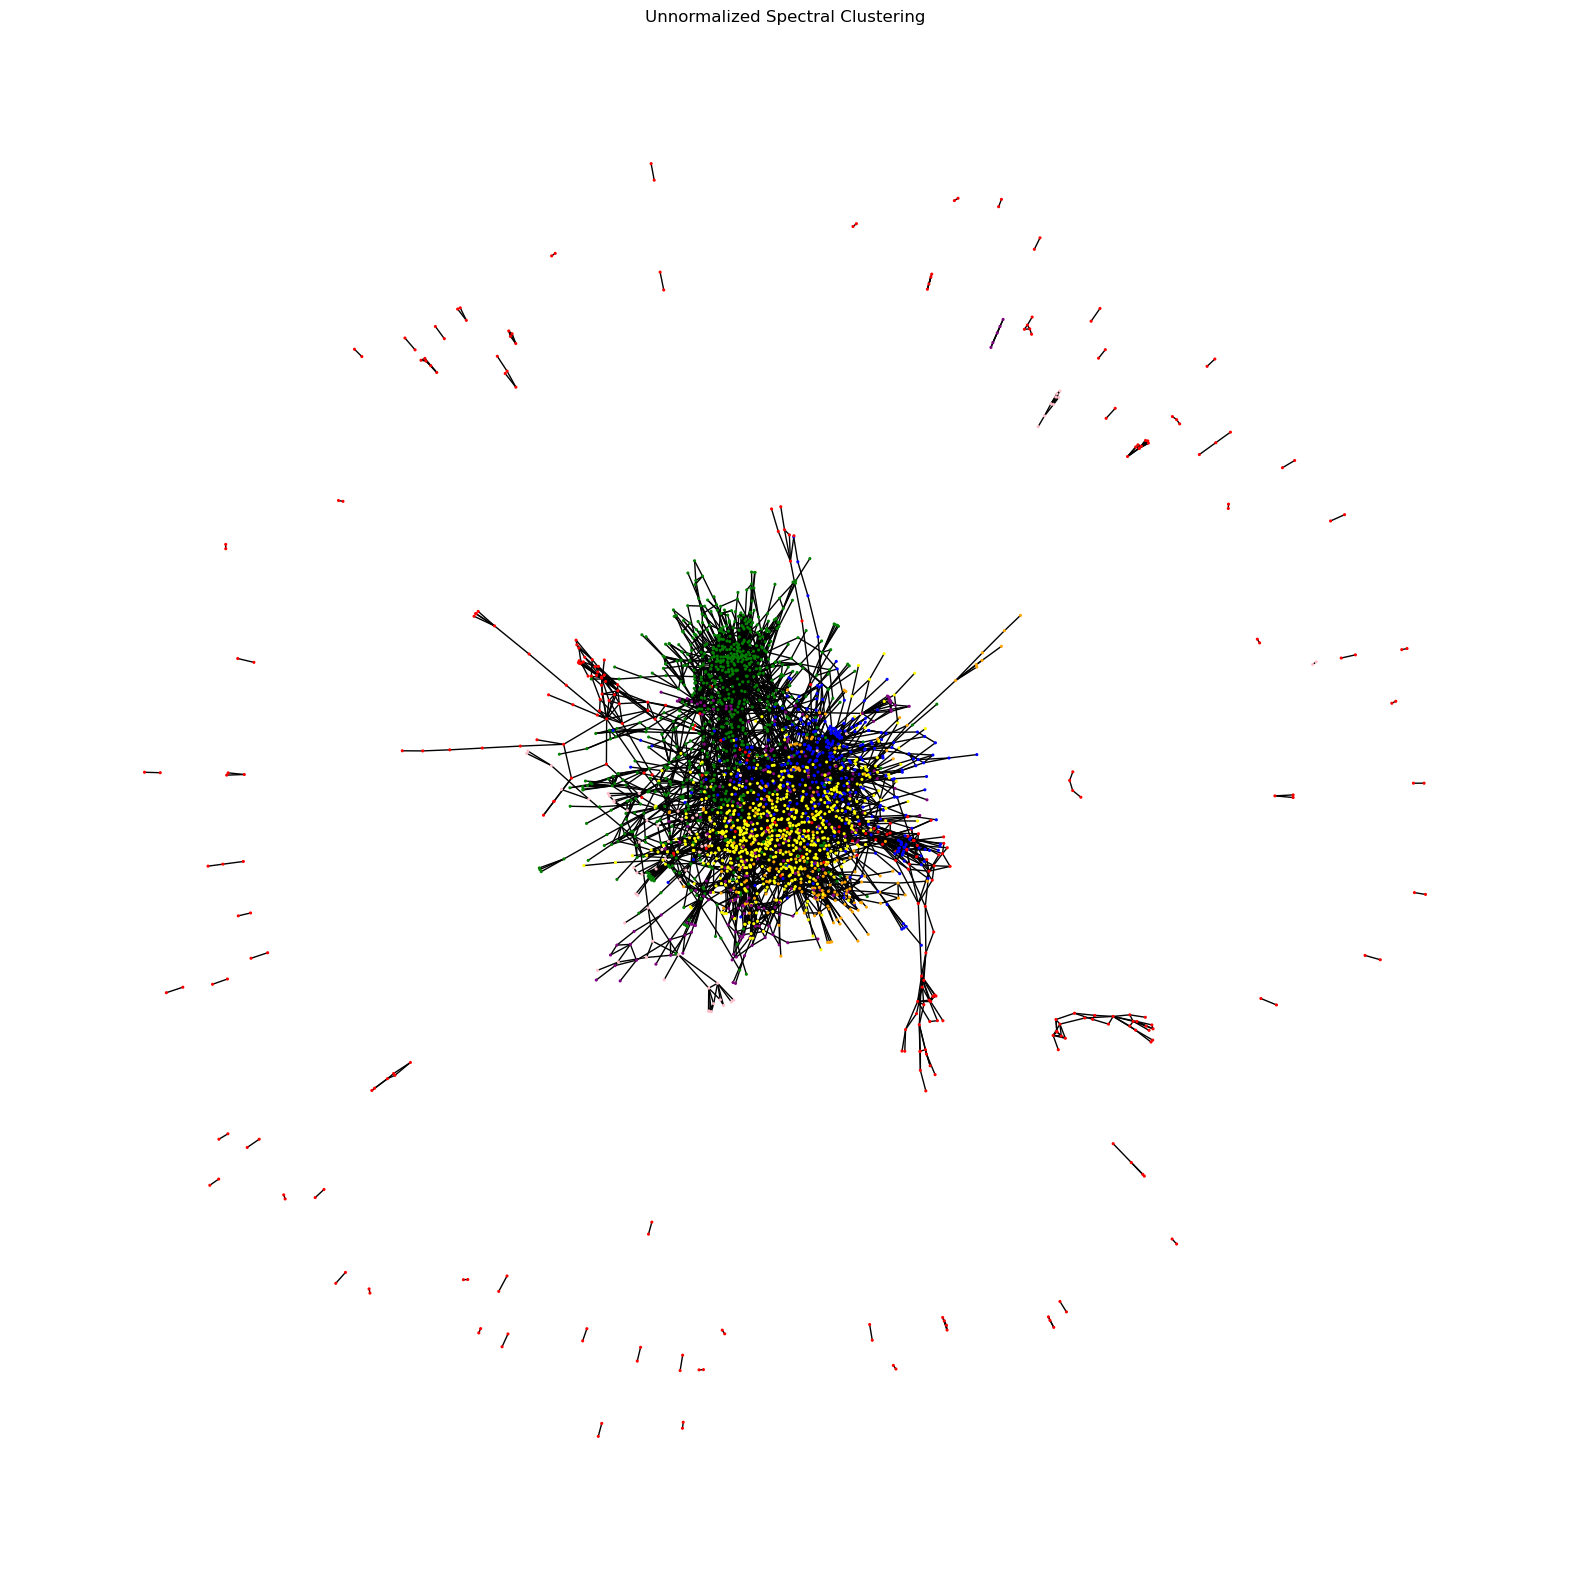

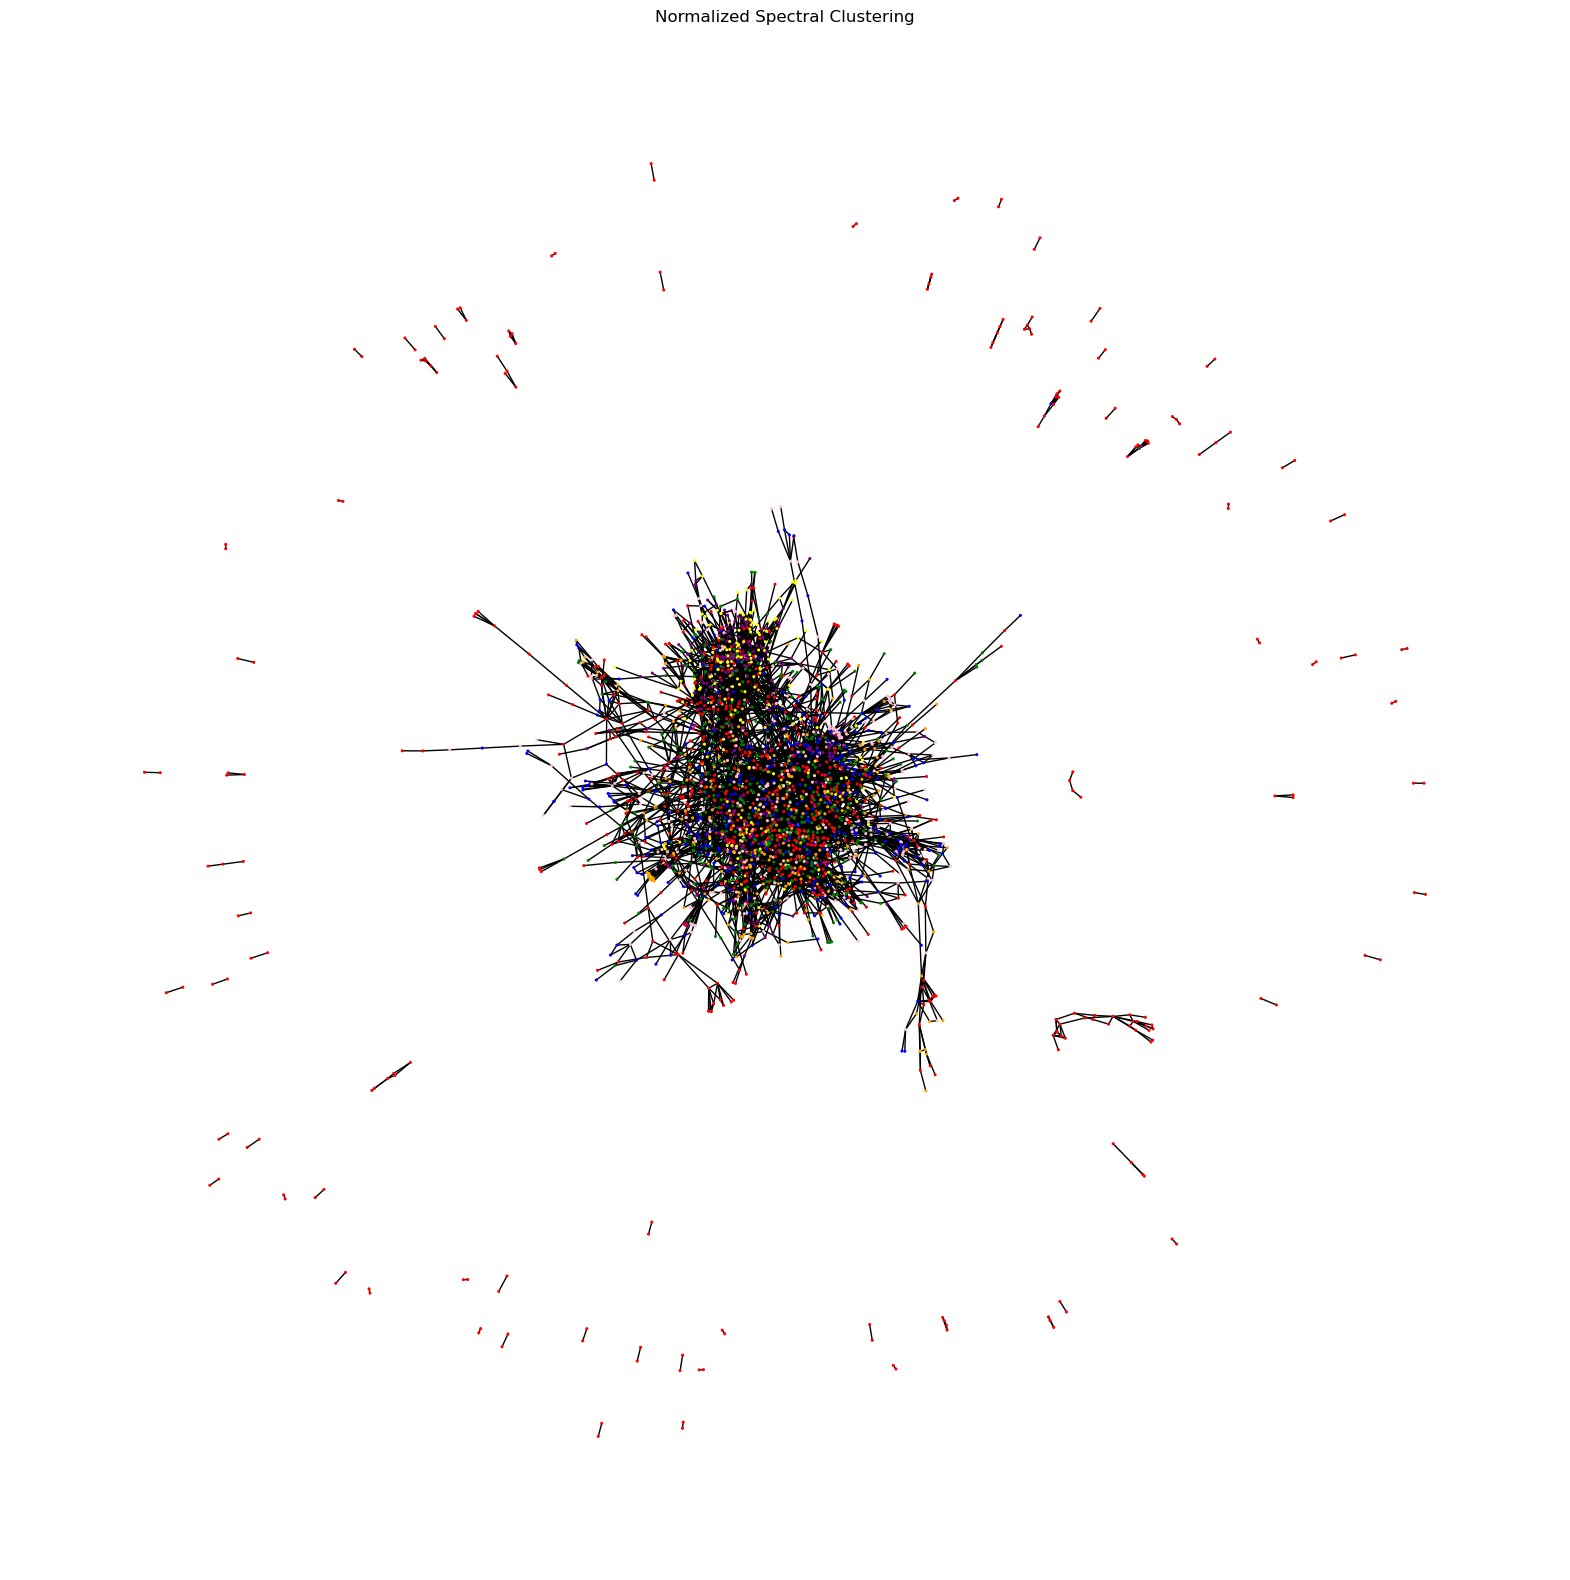

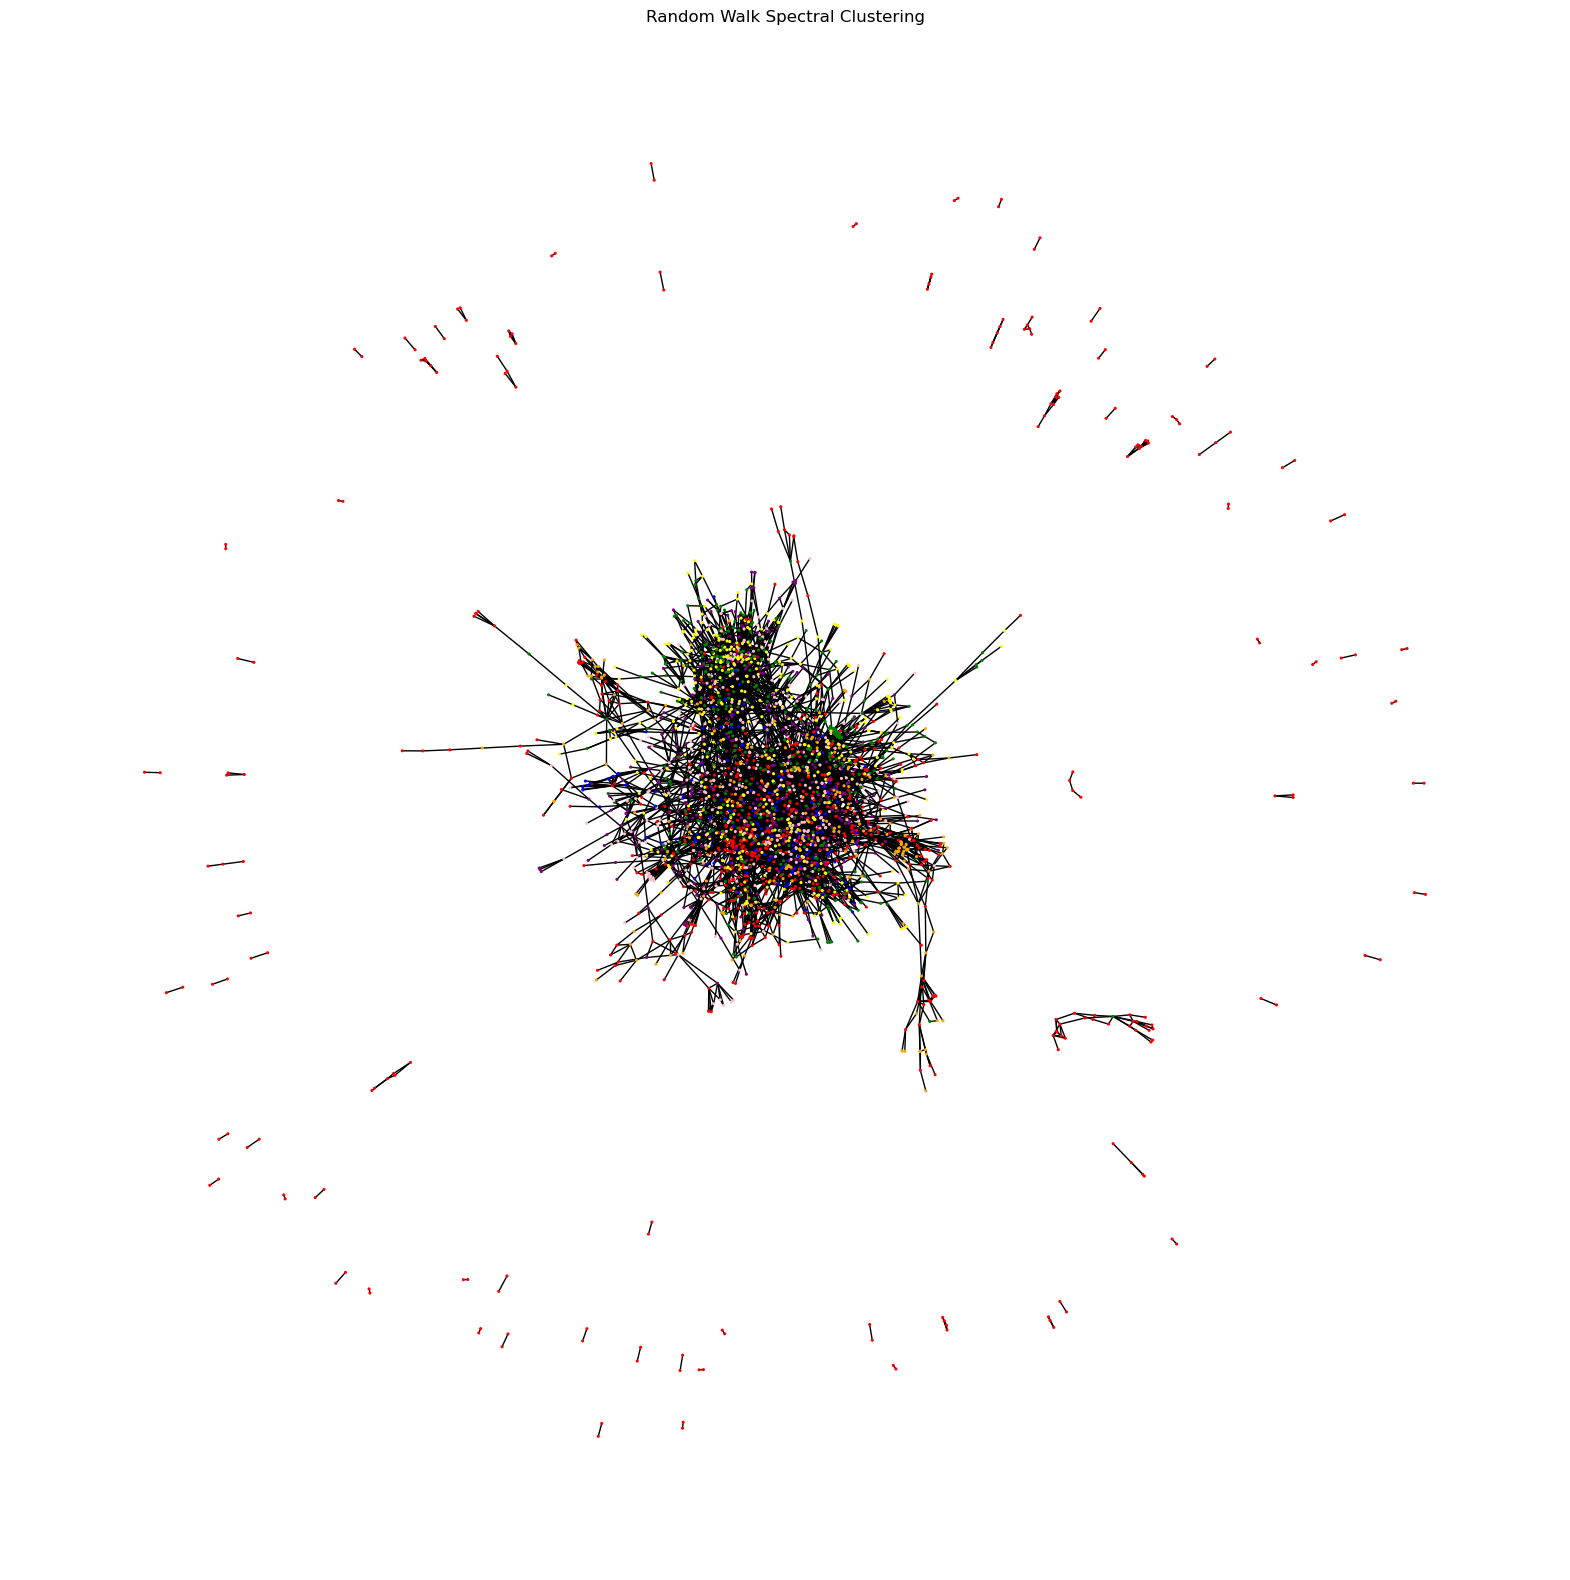

In [12]:
k = 7
V_unnormalized_cora = sorted_eigvecs_unnormalized_cora[:,78:78+k]
V_unnormalized_cora = V_unnormalized_cora/(np.linalg.norm(V_unnormalized_cora, axis=1)[:, np.newaxis] + 1e-5)

V_normalized_cora = sorted_eigvecs_normalized_cora[:,78:78+k]
V_normalized_cora = V_normalized_cora/(np.linalg.norm(V_normalized_cora, axis=1)[:, np.newaxis] + 1e-5)

V_rw_cora = sorted_eigvecs_rw_cora[:,78:78+k]
V_rw_cora = V_rw_cora/(np.linalg.norm(V_rw_cora, axis=1)[:, np.newaxis] + 1e-5)

labels_unnormalized_cora , centroids_unnormalized_cora = kmeans(V_unnormalized_cora, k)
labels_normalized_cora , centroids_normalized_cora = kmeans(V_normalized_cora, k)
labels_rw_cora , centroids_rw_cora = kmeans(V_rw_cora, k)


# Create a color map
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink']  # Add more colors if needed
color_map_unnormalized_cora = [colors[label] for label in labels_unnormalized_cora]
color_map_normalized_cora = [colors[label] for label in labels_normalized_cora]
color_map_rw_cora = [colors[label] for label in labels_rw_cora]

# Draw the graph
plt.figure(figsize=(20, 20))
plt.title('Unnormalized Spectral Clustering')
nx.draw(cora_network,layout_cora, node_color=color_map_unnormalized_cora, with_labels=False, node_size=1.5, edge_color='k')
plt.show()

plt.figure(figsize=(20, 20))
plt.title('Normalized Spectral Clustering') 
nx.draw(cora_network,layout_cora, node_color=color_map_normalized_cora, with_labels=False, node_size=1.5, edge_color='k')
plt.show()

plt.figure(figsize=(20, 20))        
plt.title('Random Walk Spectral Clustering')
nx.draw(cora_network,layout_cora, node_color=color_map_rw_cora, with_labels=False, node_size=1.5, edge_color='k')
plt.show()

In [13]:
# Convert the graph to a scipy sparse matrix
adj_citeseer = to_scipy_sparse_matrix(citeseer_graph[0].edge_index)
adj_citeseer = np.matrix(adj_citeseer.todense())

# Convert the adjacency matrix to a NumPy array
adj_citeseer = np.array(adj_citeseer)

# Find the indices of the rows that are all zeros
zero_row_indices = np.where(~adj_citeseer.any(axis=1))[0]

# Delete the rows and columns corresponding to the isolated nodes
adj_citeseer = np.delete(adj_citeseer, zero_row_indices, axis=0)
adj_citeseer = np.delete(adj_citeseer, zero_row_indices, axis=1)

print(adj_citeseer.shape)

# Compute the degree matrix
degrees_citeseer = np.array(adj_citeseer.sum(axis=1)).flatten()
D_citeseer = sp.diags(degrees_citeseer)


# Compute the unnormalized Laplacian
L_unnormalized_citeseer = D_citeseer - adj_citeseer

# Compute the normalized Laplacian
D_sqrt_inv_citeseer = sp.diags(1.0 / np.sqrt(degrees_citeseer))
L_normalized_citeseer = sp.eye(adj_citeseer.shape[0]) - D_sqrt_inv_citeseer @ adj_citeseer @ D_sqrt_inv_citeseer

# Compute the random walk Laplacian
D_inv_citeseer = sp.diags(1.0 / degrees_citeseer)
L_rw_citeseer = sp.eye(adj_citeseer.shape[0]) - D_inv_citeseer @ adj_citeseer


# Compute the eigenvalues of the Laplacians
unnormalized_eigvals_citeseer, unnormalized_eigvecs_citeseer = eig(L_unnormalized_citeseer)
normalized_eigvals_citeseer, normalized_eigvecs_citeseer = eig(L_normalized_citeseer)
rw_eigvals_citeseer, rw_eigvecs_citeseer = eig(L_rw_citeseer)

# Get the indices that would sort the eigenvalues
sort_indices_unnormalized_citeseer = np.argsort(unnormalized_eigvals_citeseer)
sort_indices_normalized_citeseer = np.argsort(normalized_eigvals_citeseer)
sort_indices_rw_citeseer = np.argsort(rw_eigvals_citeseer)

# Use these indices to sort the eigenvalues and eigenvectors
sorted_eigvals_unnormalized_citeseer = unnormalized_eigvals_citeseer[sort_indices_unnormalized_citeseer]
sorted_eigvecs_unnormalized_citeseer = unnormalized_eigvecs_citeseer[:, sort_indices_unnormalized_citeseer]

sorted_eigvals_normalized_citeseer = unnormalized_eigvals_citeseer[sort_indices_normalized_citeseer]
sorted_eigvecs_normalized_citeseer = unnormalized_eigvecs_citeseer[:, sort_indices_normalized_citeseer]

sorted_eigvals_rw_citeseer = unnormalized_eigvals_citeseer[sort_indices_rw_citeseer]
sorted_eigvecs_rw_citeseer = unnormalized_eigvecs_citeseer[:, sort_indices_rw_citeseer]

print('Unnormalized Laplacian eigenvalues:', np.sort(unnormalized_eigvals_citeseer)[389:391])
print('Normalized Laplacian eigenvalues:', np.sort(normalized_eigvals_citeseer)[389:391])
print('Random walk Laplacian eigenvalues:', np.sort(rw_eigvals_citeseer)[389:391])


(3279, 3279)
Unnormalized Laplacian eigenvalues: [8.311647e-06+0.j 6.522606e-03+0.j]
Normalized Laplacian eigenvalues: [5.96046458e-08+2.65793123e-17j 1.55473333e-03+0.00000000e+00j]
Random walk Laplacian eigenvalues: [1.81090527e-15+1.07892535e-16j 1.55471375e-03+0.00000000e+00j]


There are 390 connected components in citeseer \
The 391'st (390'th index) eigenvector is the fiedler vector

[2948 2782 1644   70 2045  263]
Converged in 9 iterations
[2948 2782 1644   70 2045  263]
Converged in 13 iterations
[2948 2782 1644   70 2045  263]
Converged in 13 iterations


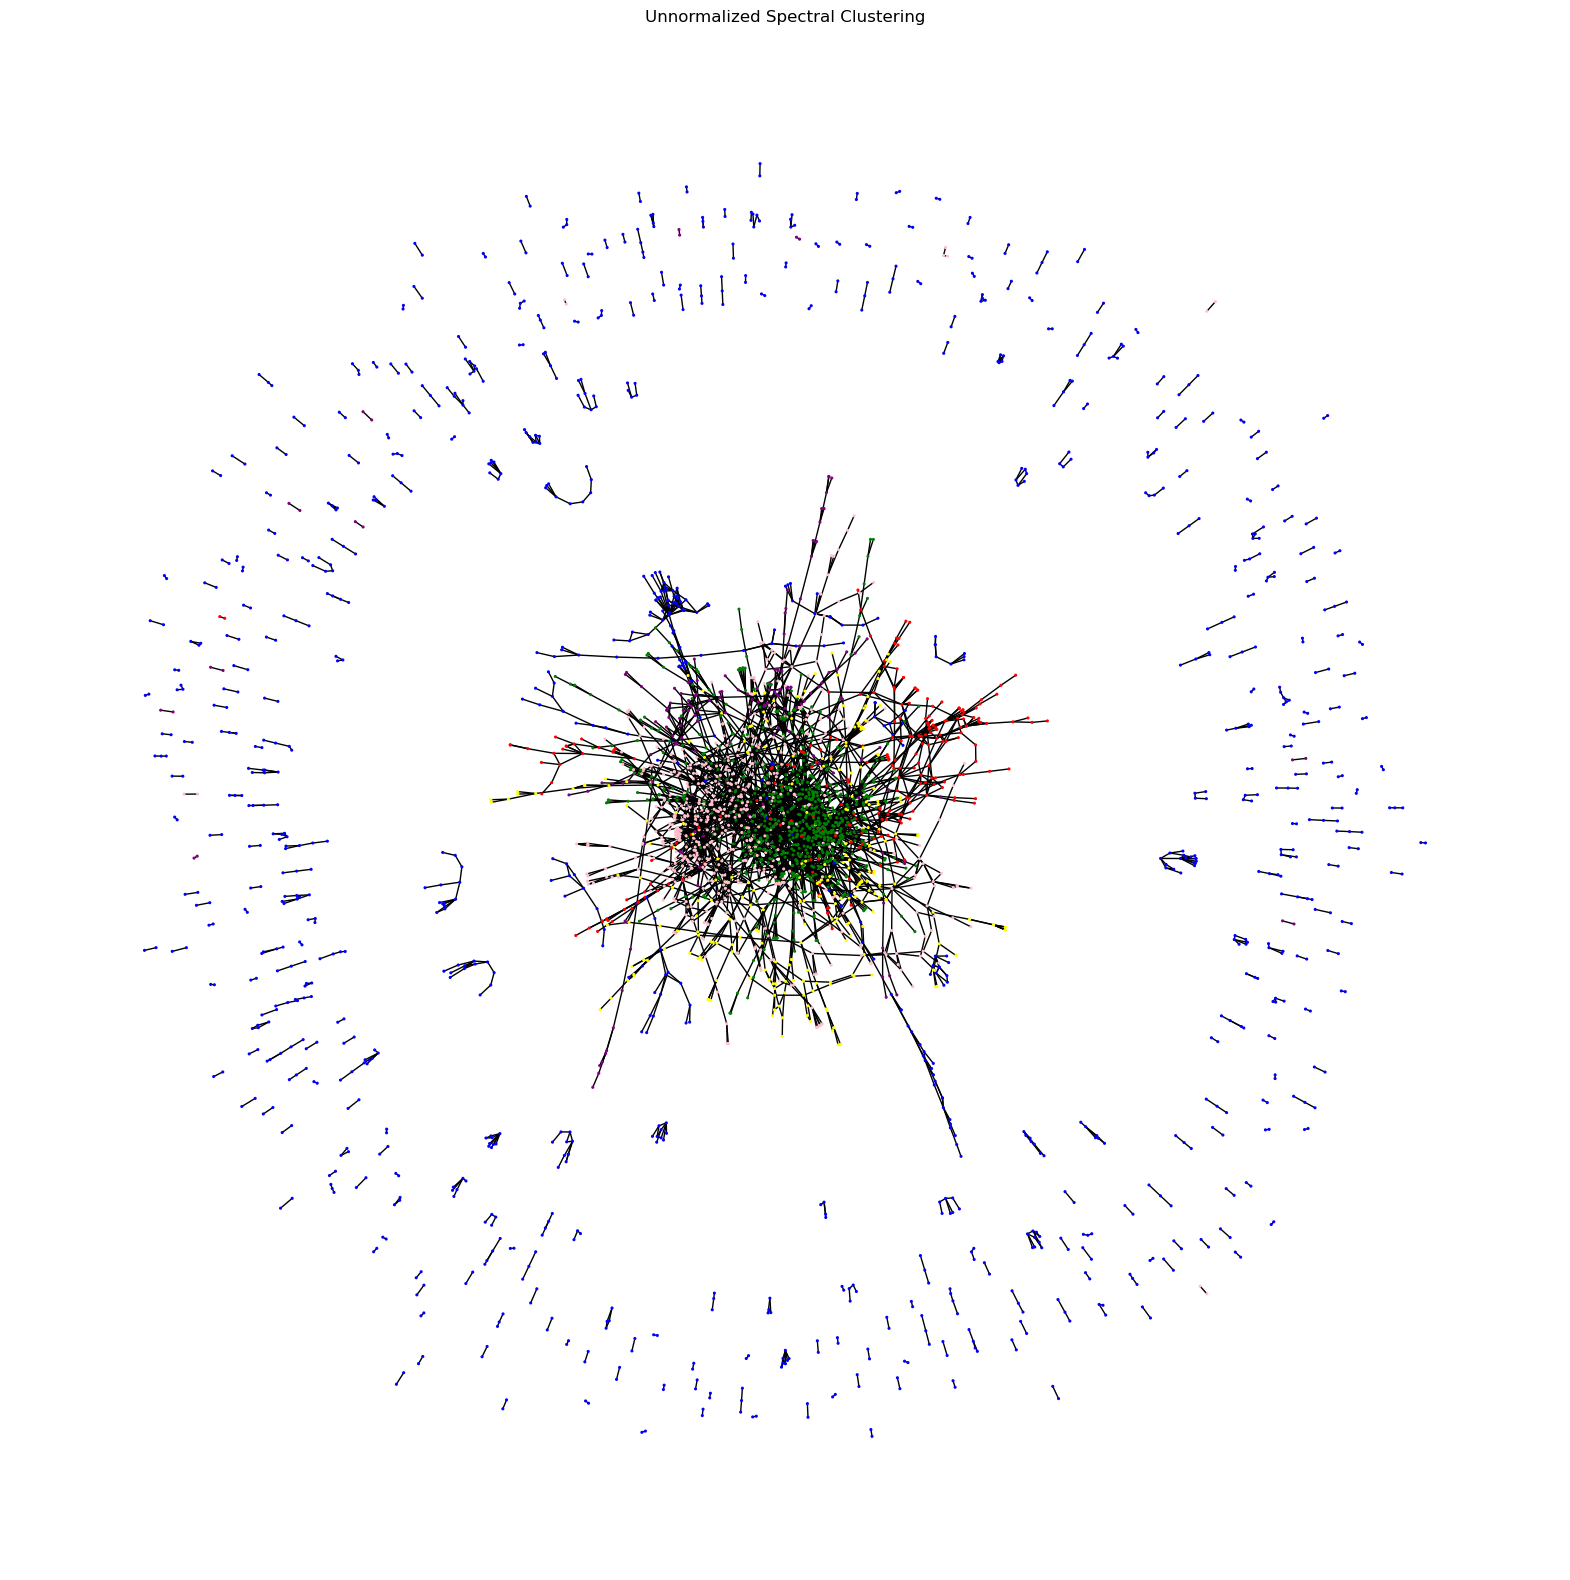

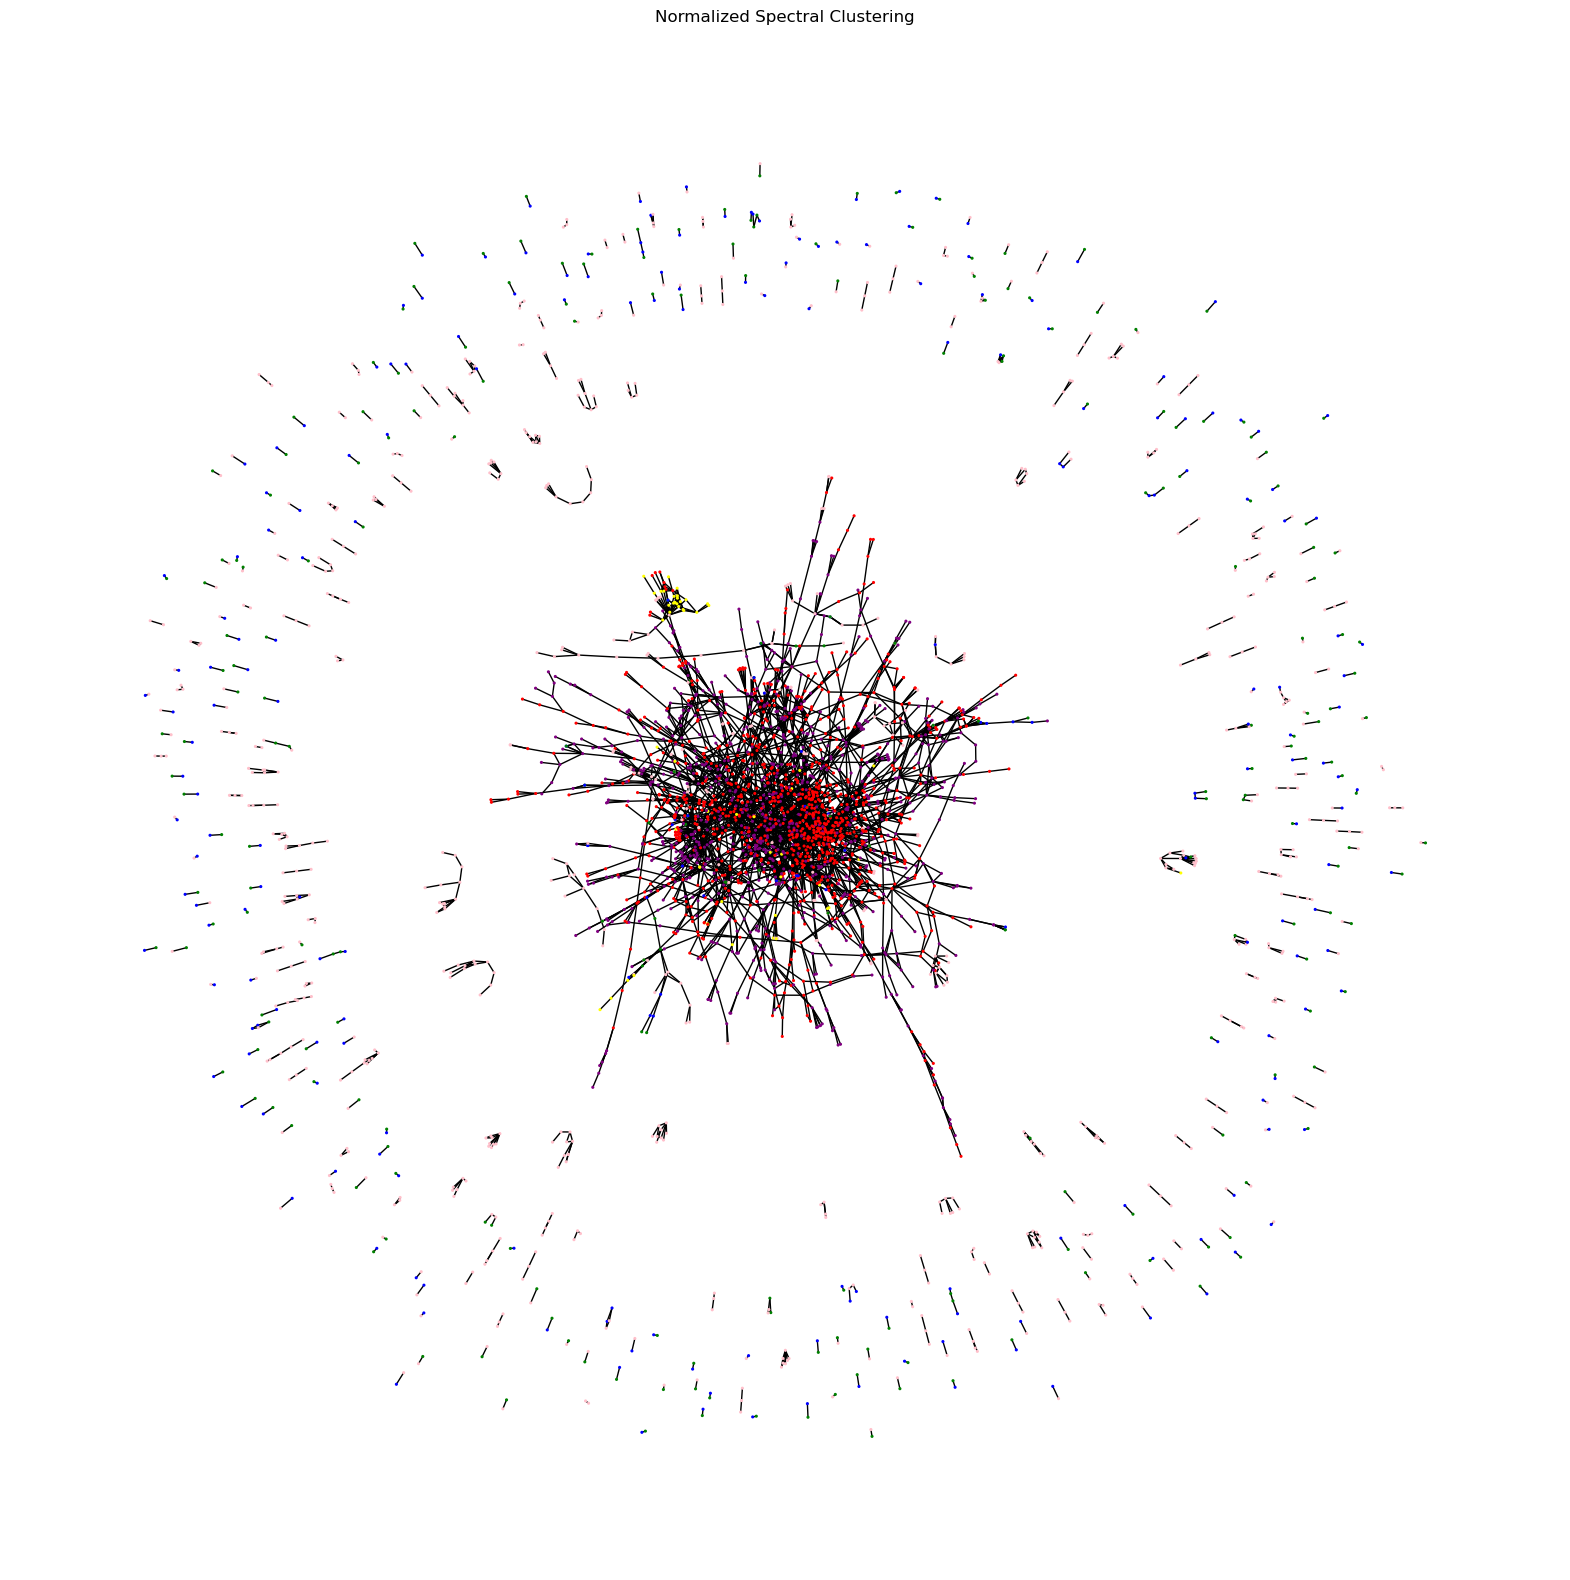

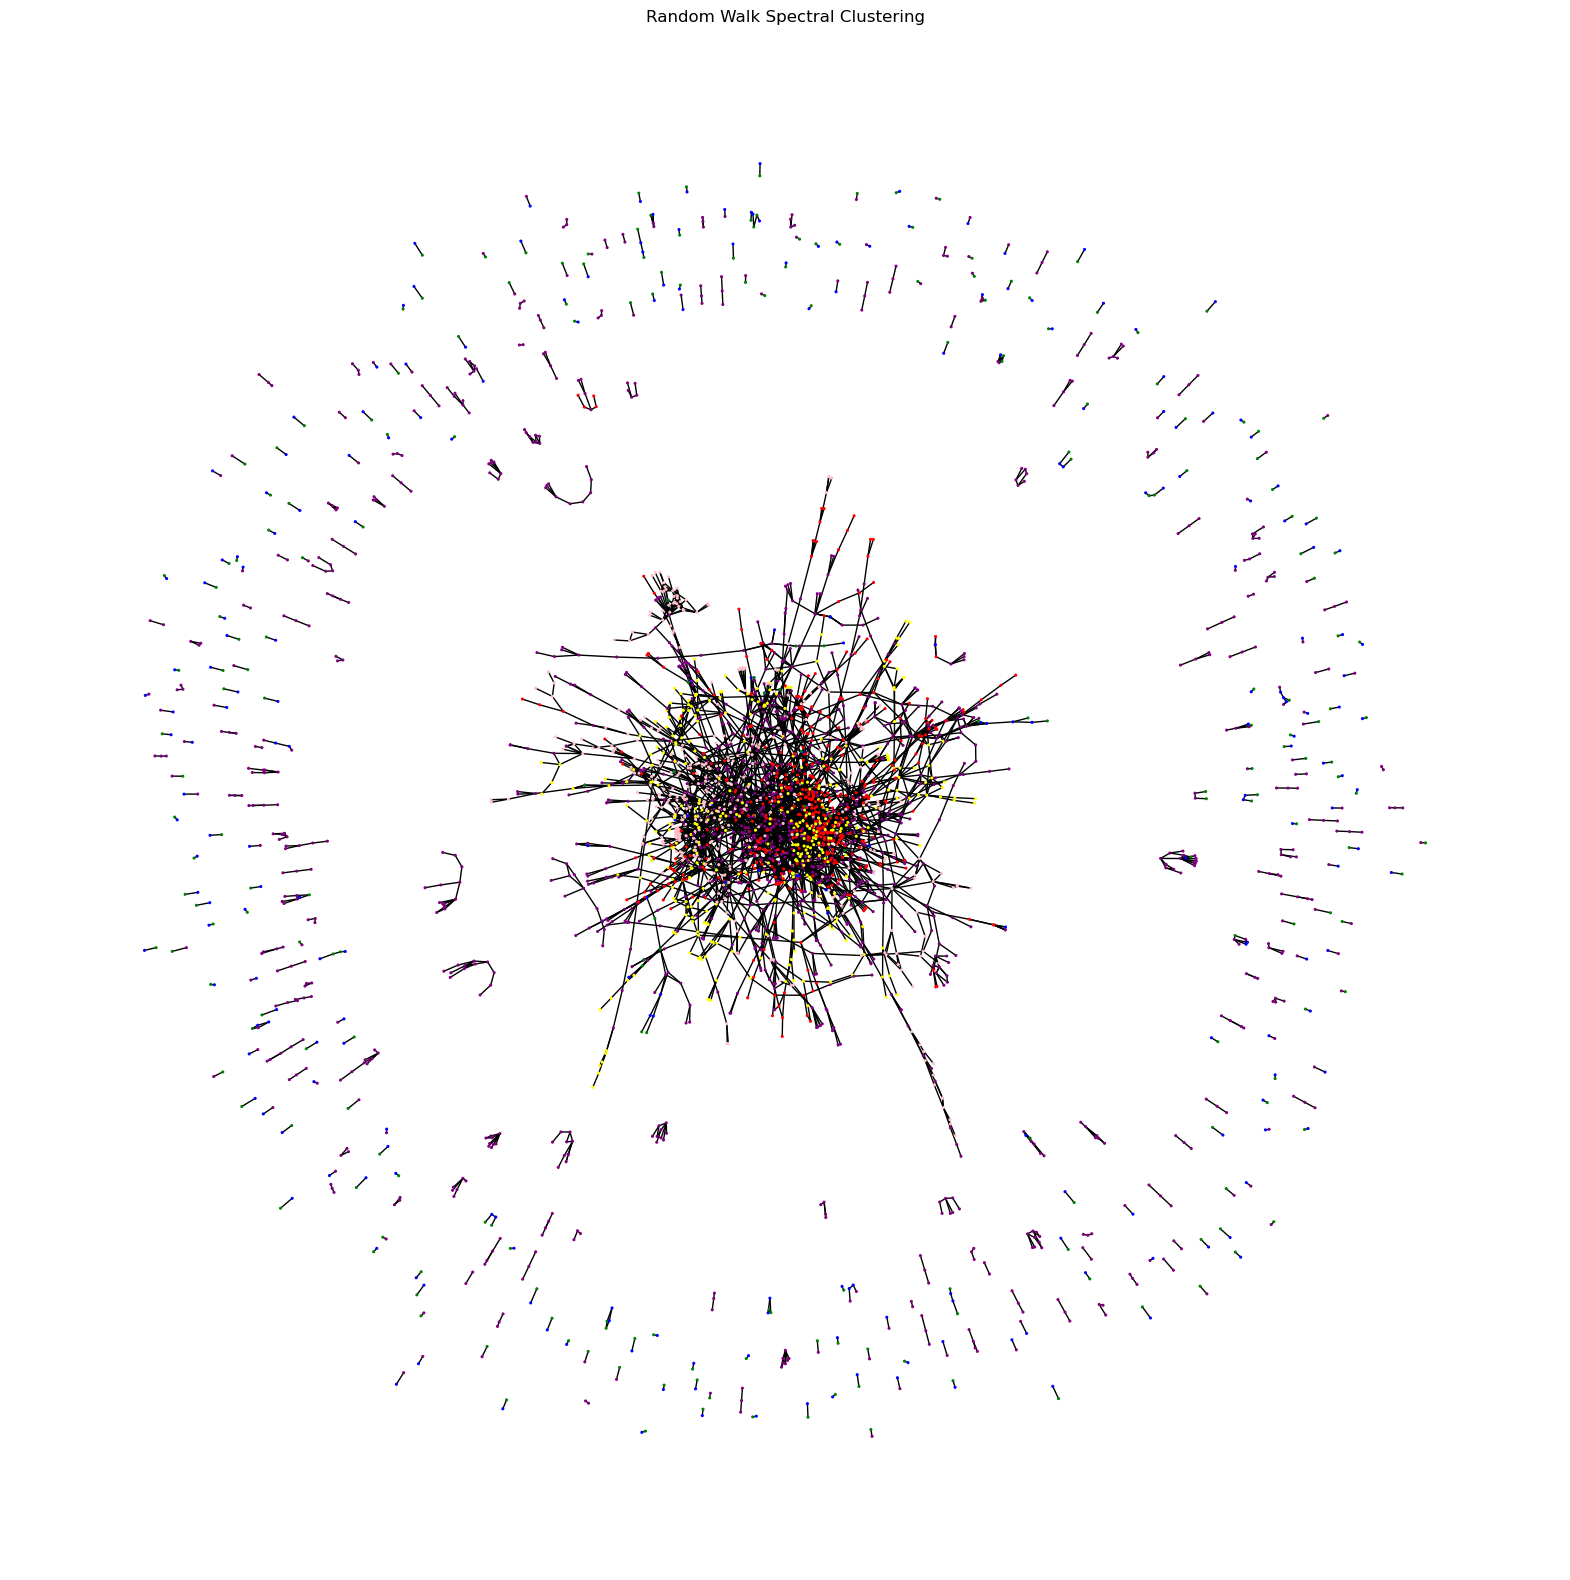

In [14]:
k = 6
V_unnormalized_citeseer = sorted_eigvecs_unnormalized_citeseer[:,390:390+k]
V_unnormalized_citeseer = V_unnormalized_citeseer/(np.linalg.norm(V_unnormalized_citeseer, axis=1)[:, np.newaxis] + 1e-5)

V_normalized_citeseer = sorted_eigvecs_normalized_citeseer[:,390:390+k]
V_normalized_citeseer = V_normalized_citeseer/(np.linalg.norm(V_normalized_citeseer, axis=1)[:, np.newaxis] + 1e-5)

V_rw_citeseer = sorted_eigvecs_rw_citeseer[:,390:390+k]
V_rw_citeseer = V_rw_citeseer/(np.linalg.norm(V_rw_citeseer, axis=1)[:, np.newaxis] + 1e-5)

labels_unnormalized_citeseer , centroids_unnormalized_citeseer = kmeans(V_unnormalized_citeseer, k)
labels_normalized_citeseer , centroids_normalized_citeseer = kmeans(V_normalized_citeseer, k)
labels_rw_citeseer , centroids_rw_citeseer = kmeans(V_rw_citeseer, k)

# Create a color map
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']  # Add more colors if needed
color_map_unnormalized_citeseer = [colors[label] for label in labels_unnormalized_citeseer]
color_map_normalized_citeseer = [colors[label] for label in labels_normalized_citeseer]
color_map_rw_citeseer = [colors[label] for label in labels_rw_citeseer]

# Draw the graph
plt.figure(figsize=(20, 20))
plt.title('Unnormalized Spectral Clustering')
nx.draw(citeseer_network,layout_citeseer, node_color=color_map_unnormalized_citeseer, with_labels=False, node_size=1.5, edge_color='k')
plt.show()

plt.figure(figsize=(20, 20))
plt.title('Normalized Spectral Clustering') 
nx.draw(citeseer_network,layout_citeseer, node_color=color_map_normalized_citeseer, with_labels=False, node_size=1.5, edge_color='k')
plt.show()

plt.figure(figsize=(20, 20))        
plt.title('Random Walk Spectral Clustering')
nx.draw(citeseer_network,layout_citeseer, node_color=color_map_rw_citeseer, with_labels=False, node_size=1.5, edge_color='k')
plt.show()

In [15]:
silhouette_score_unnormalized_cora = silhouette_score(np.real(V_unnormalized_cora), labels_unnormalized_cora, metric='euclidean')
silhouette_score_normalized_cora = silhouette_score(np.real(V_normalized_cora), labels_normalized_cora, metric='euclidean')
silhouette_score_rw_cora = silhouette_score(np.real(V_rw_cora), labels_rw_cora, metric='euclidean')
silhouette_score_unnormalized_citeseer = silhouette_score(np.real(V_unnormalized_citeseer), labels_unnormalized_citeseer, metric='euclidean')
silhouette_score_normalized_citeseer = silhouette_score(np.real(V_normalized_citeseer), labels_normalized_citeseer, metric='euclidean')
silhouette_score_rw_citeseer= silhouette_score(np.real(V_rw_citeseer), labels_rw_citeseer, metric='euclidean')


davies_bouldin_score_unnormalized_cora = davies_bouldin_score(np.real(V_unnormalized_cora), labels_unnormalized_cora)
davies_bouldin_score_normalized_cora = davies_bouldin_score(np.real(V_normalized_cora), labels_normalized_cora) 
davies_bouldin_score_rw_cora = davies_bouldin_score(np.real(V_rw_cora), labels_rw_cora)
davies_bouldin_score_unnormalized_citeseer = davies_bouldin_score(np.real(V_unnormalized_citeseer), labels_unnormalized_citeseer)
davies_bouldin_score_normalized_citeseer = davies_bouldin_score(np.real(V_normalized_citeseer), labels_normalized_citeseer)
davies_bouldin_score_rw_citeseer = davies_bouldin_score(np.real(V_rw_citeseer), labels_rw_citeseer)

print('Silhouette Score for Unnormalized Laplacian Cora:', silhouette_score_unnormalized_cora)
print('Silhouette Score for Normalized Laplacian Cora:', silhouette_score_normalized_cora)
print('Silhouette Score for Random Walk Laplacian Cora:', silhouette_score_rw_cora)
print()
print('='*80)
print()
print('Silhouette Score for Unnormalized Laplacian Citeseer:', silhouette_score_unnormalized_citeseer)
print('Silhouette Score for Normalized Laplacian Citeseer:', silhouette_score_normalized_citeseer)
print('Silhouette Score for Random Walk Laplacian Citeseer:', silhouette_score_rw_citeseer)
print()
print('='*80)
print()
print('Davies Bouldin Score for Unnormalized Laplacian Cora:', davies_bouldin_score_unnormalized_cora)
print('Davies Bouldin Score for Normalized Laplacian Cora:', davies_bouldin_score_normalized_cora)
print('Davies Bouldin Score for Random Walk Laplacian Cora:', davies_bouldin_score_rw_cora)
print()
print('='*80)
print()
print('Davies Bouldin Score for Unnormalized Laplacian Citeseer:', davies_bouldin_score_unnormalized_citeseer)
print('Davies Bouldin Score for Normalized Laplacian Citeseer:', davies_bouldin_score_normalized_citeseer)
print('Davies Bouldin Score for Random Walk Laplacian Citeseer:', davies_bouldin_score_rw_citeseer)

Silhouette Score for Unnormalized Laplacian Cora: 0.4161406
Silhouette Score for Normalized Laplacian Cora: 0.2749059
Silhouette Score for Random Walk Laplacian Cora: 0.3009346


Silhouette Score for Unnormalized Laplacian Citeseer: 0.5723505
Silhouette Score for Normalized Laplacian Citeseer: 0.6570553
Silhouette Score for Random Walk Laplacian Citeseer: 0.35721862


Davies Bouldin Score for Unnormalized Laplacian Cora: 1.0450724349135139
Davies Bouldin Score for Normalized Laplacian Cora: 1.4188195030466415
Davies Bouldin Score for Random Walk Laplacian Cora: 1.3303948072569356


Davies Bouldin Score for Unnormalized Laplacian Citeseer: 1.0364056055562612
Davies Bouldin Score for Normalized Laplacian Citeseer: 1.033957444806063
Davies Bouldin Score for Random Walk Laplacian Citeseer: 1.2289696940085864


Higher Silhouette score is better [-1,1]\
Lower Davies-Bouldin score is better [0,inf)

Question 2).

Graph Learning


MNIST dataset has 70k 28*28 images

/Users/sid/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


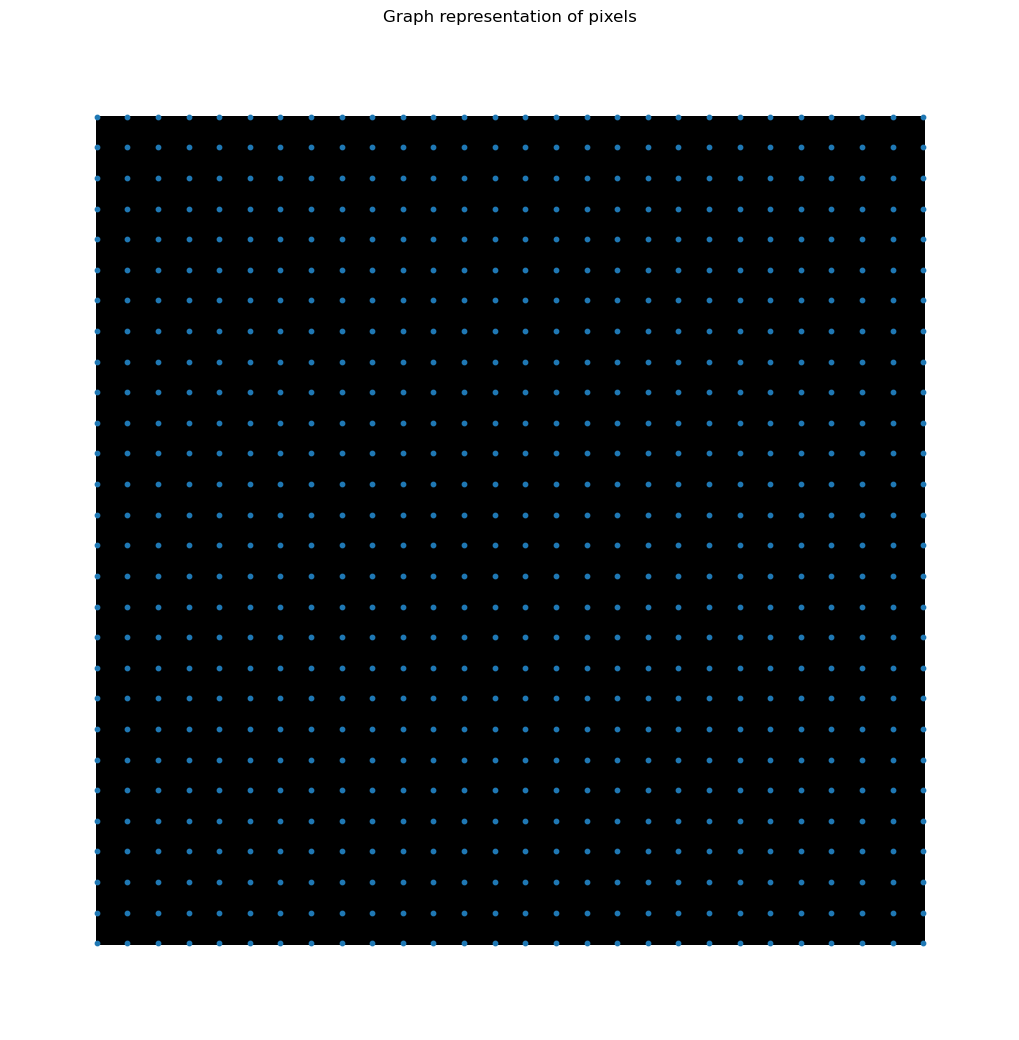

/Users/sid/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:268: RuntimeWarning: divide by zero encountered in scalar divide
  precision_[idx, idx] = 1.0 / (
/Users/sid/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/Users/sid/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/Users/sid/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:268: RuntimeWarning: divide by zero encountered in scalar divide
  precision_[idx, idx] = 1.0 / (
/Users/sid/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, id

FloatingPointError: The system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X.shape)

# Define nodes (pixels) and construct a simple grid graph
num_pixels = X.shape[1]
side_length = int(np.sqrt(num_pixels))
nodes = [(i, j) for i in range(side_length) for j in range(side_length)]
edges = [(nodes[i], nodes[j]) for i in range(num_pixels) for j in range(i+1, num_pixels)]

# Construct a graph using NetworkX
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

# Visualize the graph
pos = {node: (node[1], -node[0]) for node in nodes}  # Flip y-axis for better visualization
plt.figure(figsize=(10, 10))
nx.draw(graph, pos, with_labels=False, node_size=10)
plt.title('Graph representation of pixels')
plt.show()

model = GraphicalLassoCV(cv=5, max_iter=1000)
model.fit(X)

# The learned adjacency matrix is the non-zero elements of the inverse covariance matrix
adjacency_matrix = model.precision_ != 0

# Visualize the precision matrix as an adjacency matrix
plt.figure(figsize=(10, 10))
plt.imshow(model.precision_, cmap='hot', interpolation='nearest')
plt.title('Precision matrix (adjacency matrix)')
plt.colorbar()
plt.show()
